In [ ]:
!pip install tab-transformer-pytorch imbalanced-learn

## Importing Necessary Libraries

In [ ]:
from IPython import get_ipython
from IPython.display import display

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

## Loading and Data Preprocessing

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/2. AI ML Projects + Datasets/Network Intrusion Detection System Using BERT Model/CIC-IDS2017 (parquet)"
all_files = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith('.parquet')]
df = pd.concat((pd.read_parquet(file) for file in all_files), axis=0, ignore_index=True)
# df = df.sample(frac=0.75, random_state=42).reset_index(drop=True)

In [ ]:
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Label encoding for Binary Classification
def label_encode(y):
    return np.where(y == 'Benign', 0, 1)
df['Label'] = label_encode(df['Label'])

In [ ]:
# Feature-target split
X = df.drop('Label', axis=1)
y = df['Label']

<ipython-input-7-29c23e36d780>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set1')


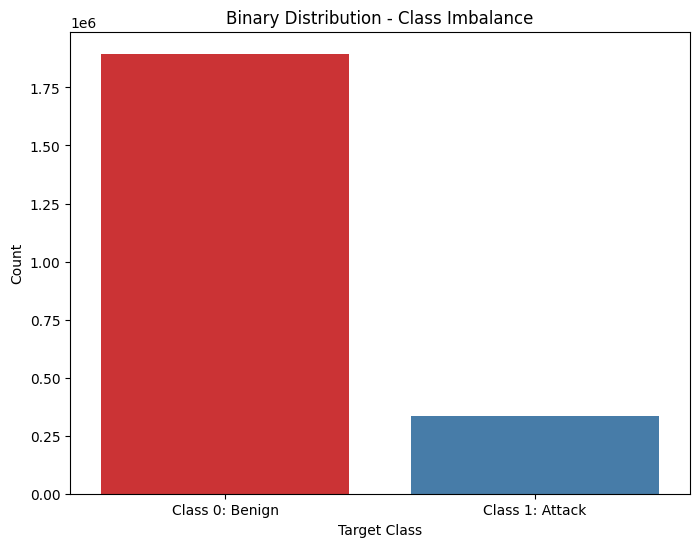

Class 0 ratio: 84.92%
Class 1 ratio: 15.08%


In [ ]:
# Visualizing Dataset Imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette='Set1')
plt.title('Binary Distribution - Class Imbalance')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Class 0: Benign', 'Class 1: Attack'])

plt.show()

class_counts = y.value_counts()
class_ratios = class_counts / len(y)

# Print the ratio of each class
print(f"Class 0 ratio: {class_ratios[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios[1]*100:.2f}%")

### Handling Class Imbalance using BorderlineSMOTE and RandomUnderSampler

In [ ]:
# Handle class imbalance using BorderlineSMOTE and RandomUnderSampler
smote = BorderlineSMOTE(random_state=42, kind='borderline-1')
X_resampled, y_resampled = smote.fit_resample(X, y)

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The BorderlineSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.ut

<ipython-input-9-19e0f489081a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='Set1')  # Use y_res instead of y


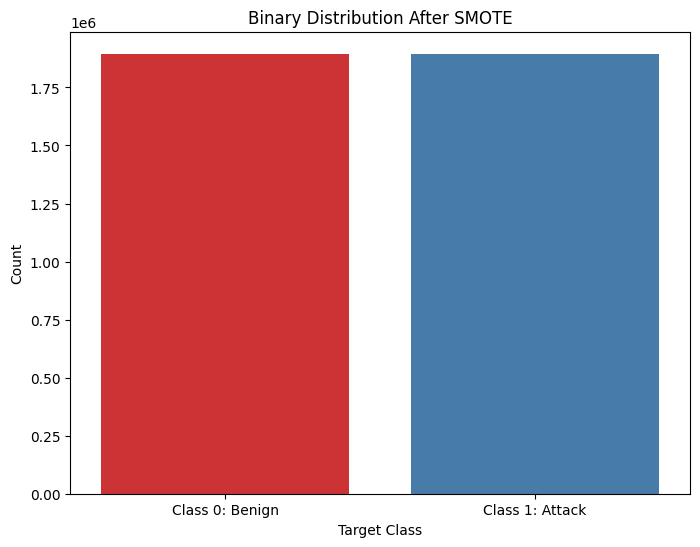

In [ ]:
# Visualizing Dataset Distribution After SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette='Set1')
plt.title('Binary Distribution After SMOTE')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Class 0: Benign', 'Class 1: Attack'])

plt.show()

### Train-Test-Split

In [ ]:
# Train-test split (after handling imbalance)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
# Scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


## Create DataLoader

In [ ]:
# Create DataLoader
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_tensor, y_train_tensor)
val_dataset = TabularDataset(X_val_tensor, y_val_tensor)
test_dataset = TabularDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

## Define the Model

In [ ]:
# Define the Model
class TabTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_heads=4, num_layers=2):
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x.unsqueeze(1))
        x = x.mean(dim=1)
        return self.classifier(x)

In [ ]:
# Initialize TabTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_tensor.shape[1]
num_classes = len(y.unique())
model = TabTransformer(input_dim=input_dim, num_classes=num_classes)

# Training configuration
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1., 5.], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TabTransformer(
  (embedding): Linear(in_features=77, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

## Model Training

In [ ]:
# Training loop with accuracy and loss tracking
epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    # Print metrics for the epoch
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%')
    print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')
    print('-' * 30)

Epoch [1/10]
Train Loss: 0.0650, Train Acc: 95.09%
Val Loss: 0.0484, Val Acc: 96.22%
------------------------------
Epoch [2/10]
Train Loss: 0.0442, Train Acc: 96.78%
Val Loss: 0.0355, Val Acc: 97.44%
------------------------------
Epoch [3/10]
Train Loss: 0.0350, Train Acc: 97.61%
Val Loss: 0.0265, Val Acc: 98.16%
------------------------------
Epoch [4/10]
Train Loss: 0.0289, Train Acc: 98.02%
Val Loss: 0.0227, Val Acc: 98.37%
------------------------------
Epoch [5/10]
Train Loss: 0.0262, Train Acc: 98.23%
Val Loss: 0.0227, Val Acc: 98.34%
------------------------------
Epoch [6/10]
Train Loss: 0.0245, Train Acc: 98.35%
Val Loss: 0.0216, Val Acc: 98.38%
------------------------------
Epoch [7/10]
Train Loss: 0.0239, Train Acc: 98.43%
Val Loss: 0.0202, Val Acc: 98.52%
------------------------------
Epoch [8/10]
Train Loss: 0.0226, Train Acc: 98.50%
Val Loss: 0.0214, Val Acc: 98.41%
------------------------------
Epoch [9/10]
Train Loss: 0.0218, Train Acc: 98.57%
Val Loss: 0.0177, Val

## Model Evaluation

In [ ]:
# Evaluation

model.eval()
predictions, true_labels, prediction_probs = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        prediction_probs.extend(probs.cpu().numpy())
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(y_batch.cpu().numpy())

# Metrics
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Precision:", precision_score(true_labels, predictions))
print("Recall:", recall_score(true_labels, predictions))
print("F1 Score:", f1_score(true_labels, predictions))
print("MCC Score:", matthews_corrcoef(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))
print("AUC-ROC:", roc_auc_score(true_labels, prediction_probs))

Accuracy: 0.9855907983714243
Precision: 0.9738063205293649
Recall: 0.9980267115024077
F1 Score: 0.9857677642378814
MCC Score: 0.9714821278120528
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    284298
           1       0.97      1.00      0.99    284297

    accuracy                           0.99    568595
   macro avg       0.99      0.99      0.99    568595
weighted avg       0.99      0.99      0.99    568595

AUC-ROC: 0.9987176074339819


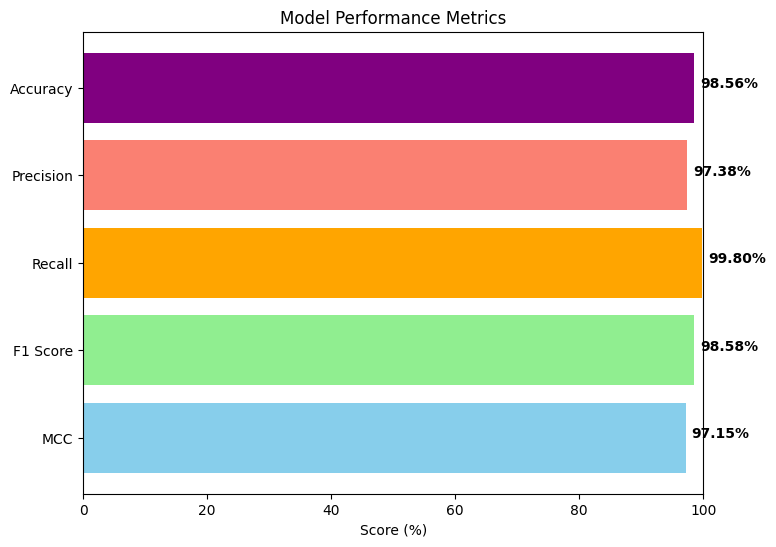

In [ ]:
# Metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
mcc = matthews_corrcoef(true_labels, predictions)

# Visualization
metrics = ['MCC' ,'F1 Score', 'Recall', 'Precision', 'Accuracy']
values = [mcc, f1, recall, precision, accuracy]

values_percentage = [v * 100 for v in values]

plt.figure(figsize=(8, 6))
plt.barh(metrics, values_percentage, color=['skyblue', 'lightgreen', 'orange', 'salmon', 'purple'])
plt.xlabel('Score (%)')
plt.title('Model Performance Metrics')
plt.xlim([0, 100])

# Update text labels to show percentage
for i, v in enumerate(values_percentage):
    plt.text(v + 1, i, f'{v:.2f}%', color='black', fontweight='bold')

plt.show()

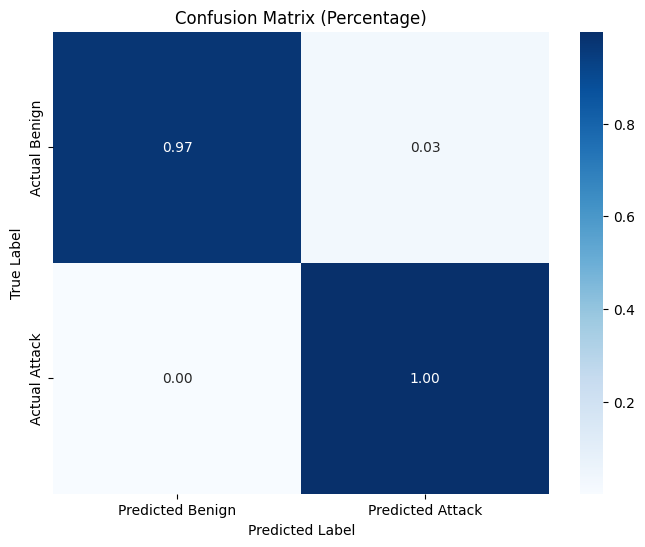

In [ ]:
# Confusion Matrix Calculation
cm = confusion_matrix(true_labels, predictions)

# Convert to Percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=['Predicted Benign', 'Predicted Attack'],
            yticklabels=['Actual Benign', 'Actual Attack'])
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

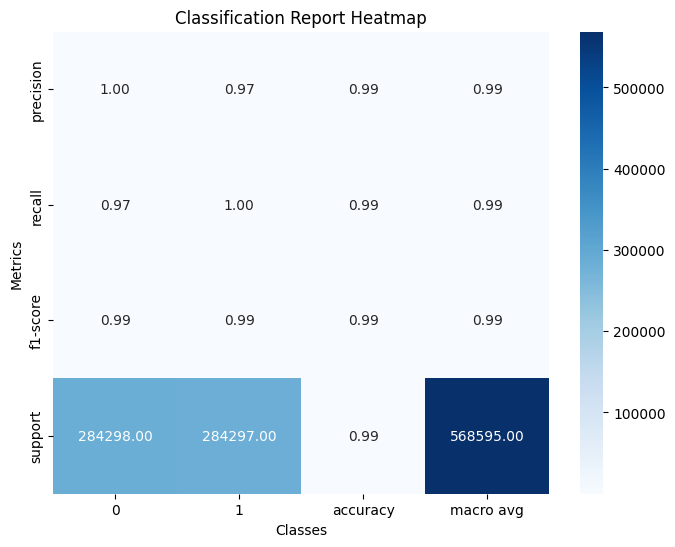

In [ ]:
# Classification Report Calculation
report = classification_report(true_labels, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f")
plt.xlabel("Classes")
plt.ylabel("Metrics")
plt.title("Classification Report Heatmap")
plt.show()

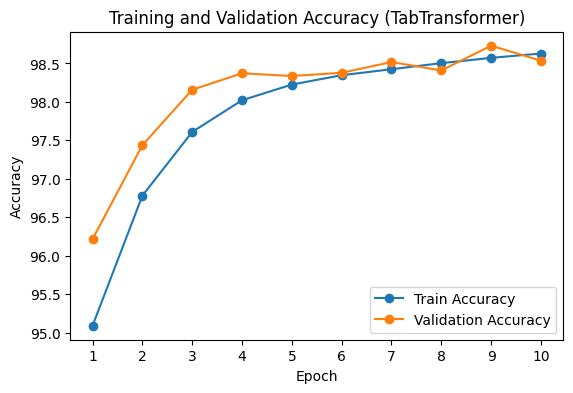

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', linestyle='-', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='-', marker='o')
plt.title('Training and Validation Accuracy (TabTransformer)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(len(train_accuracies)), range(1, len(train_accuracies) + 1))
plt.legend()

plt.show()

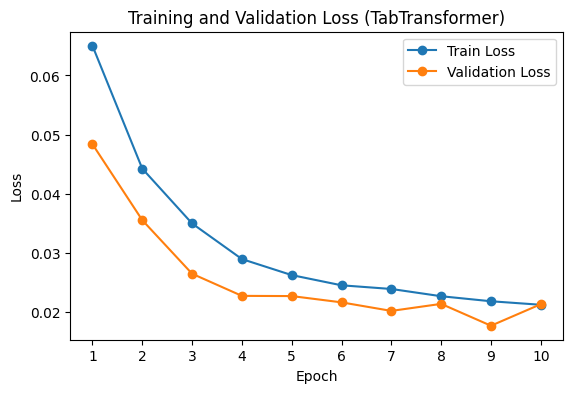

In [ ]:
# Visualization Test and Validation Loss of Epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linestyle='-', marker='o')
plt.plot(val_losses, label='Validation Loss', linestyle='-', marker='o')
plt.title('Training and Validation Loss (TabTransformer)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))

plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

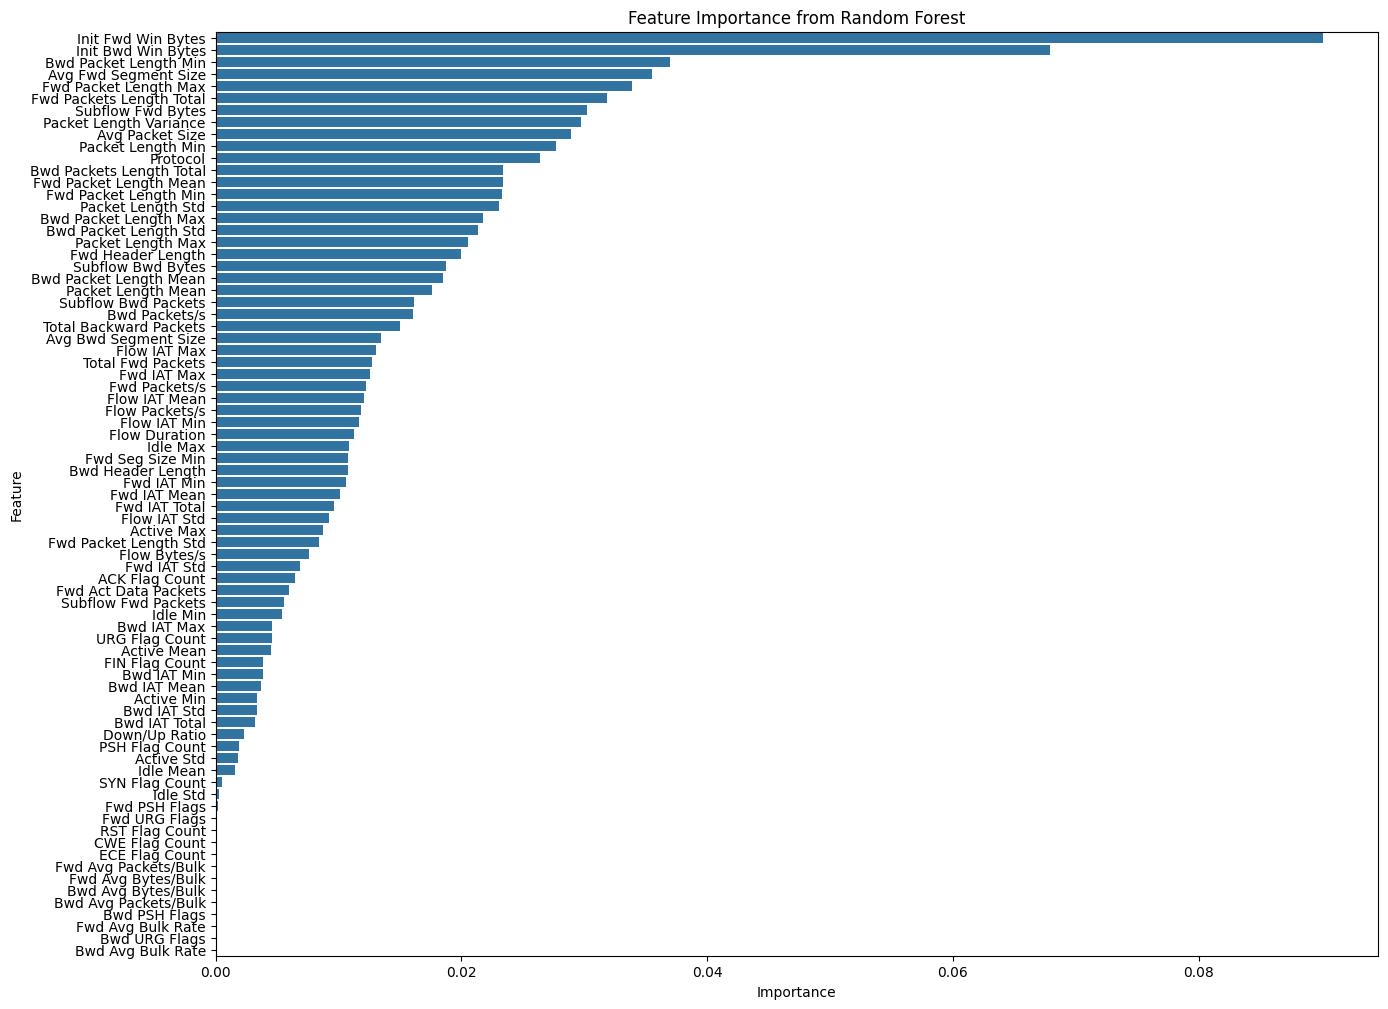

In [ ]:
# Plot feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

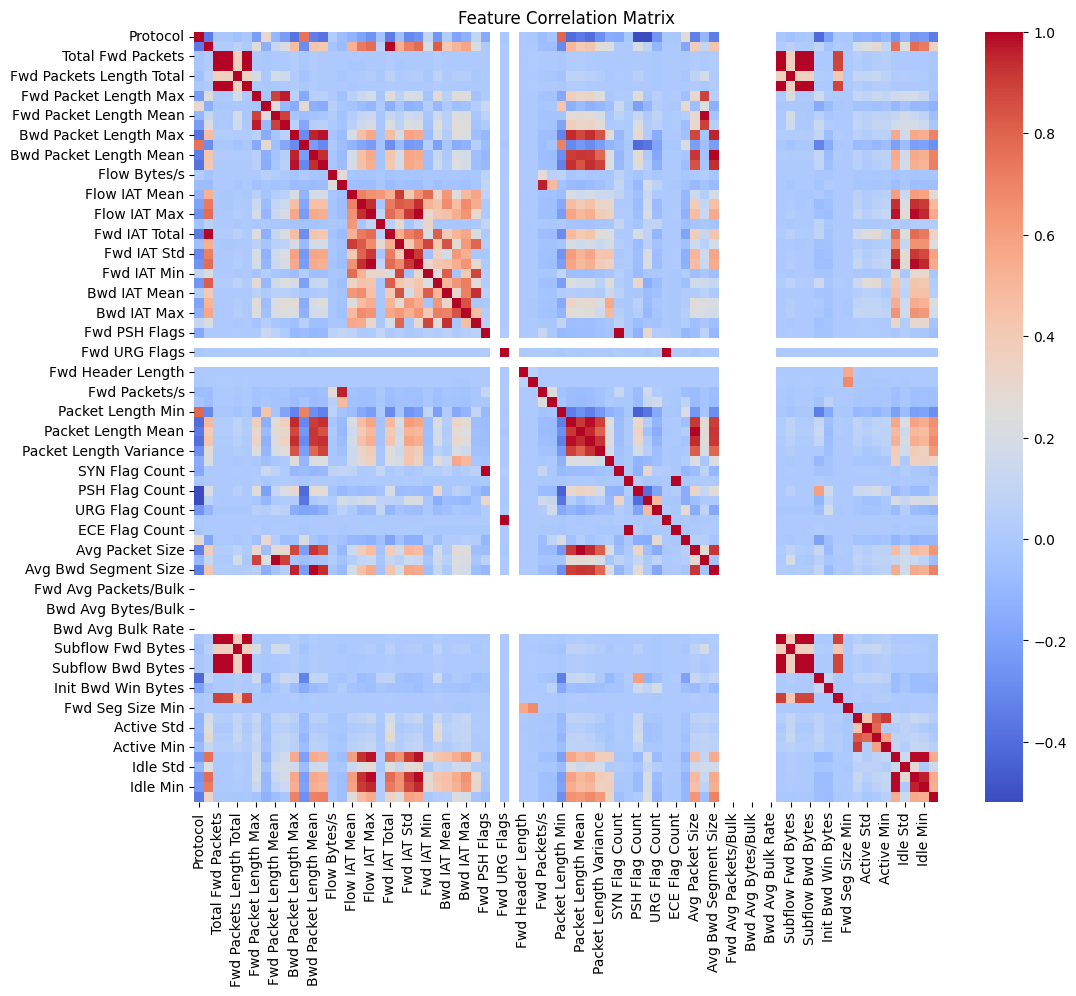

In [ ]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

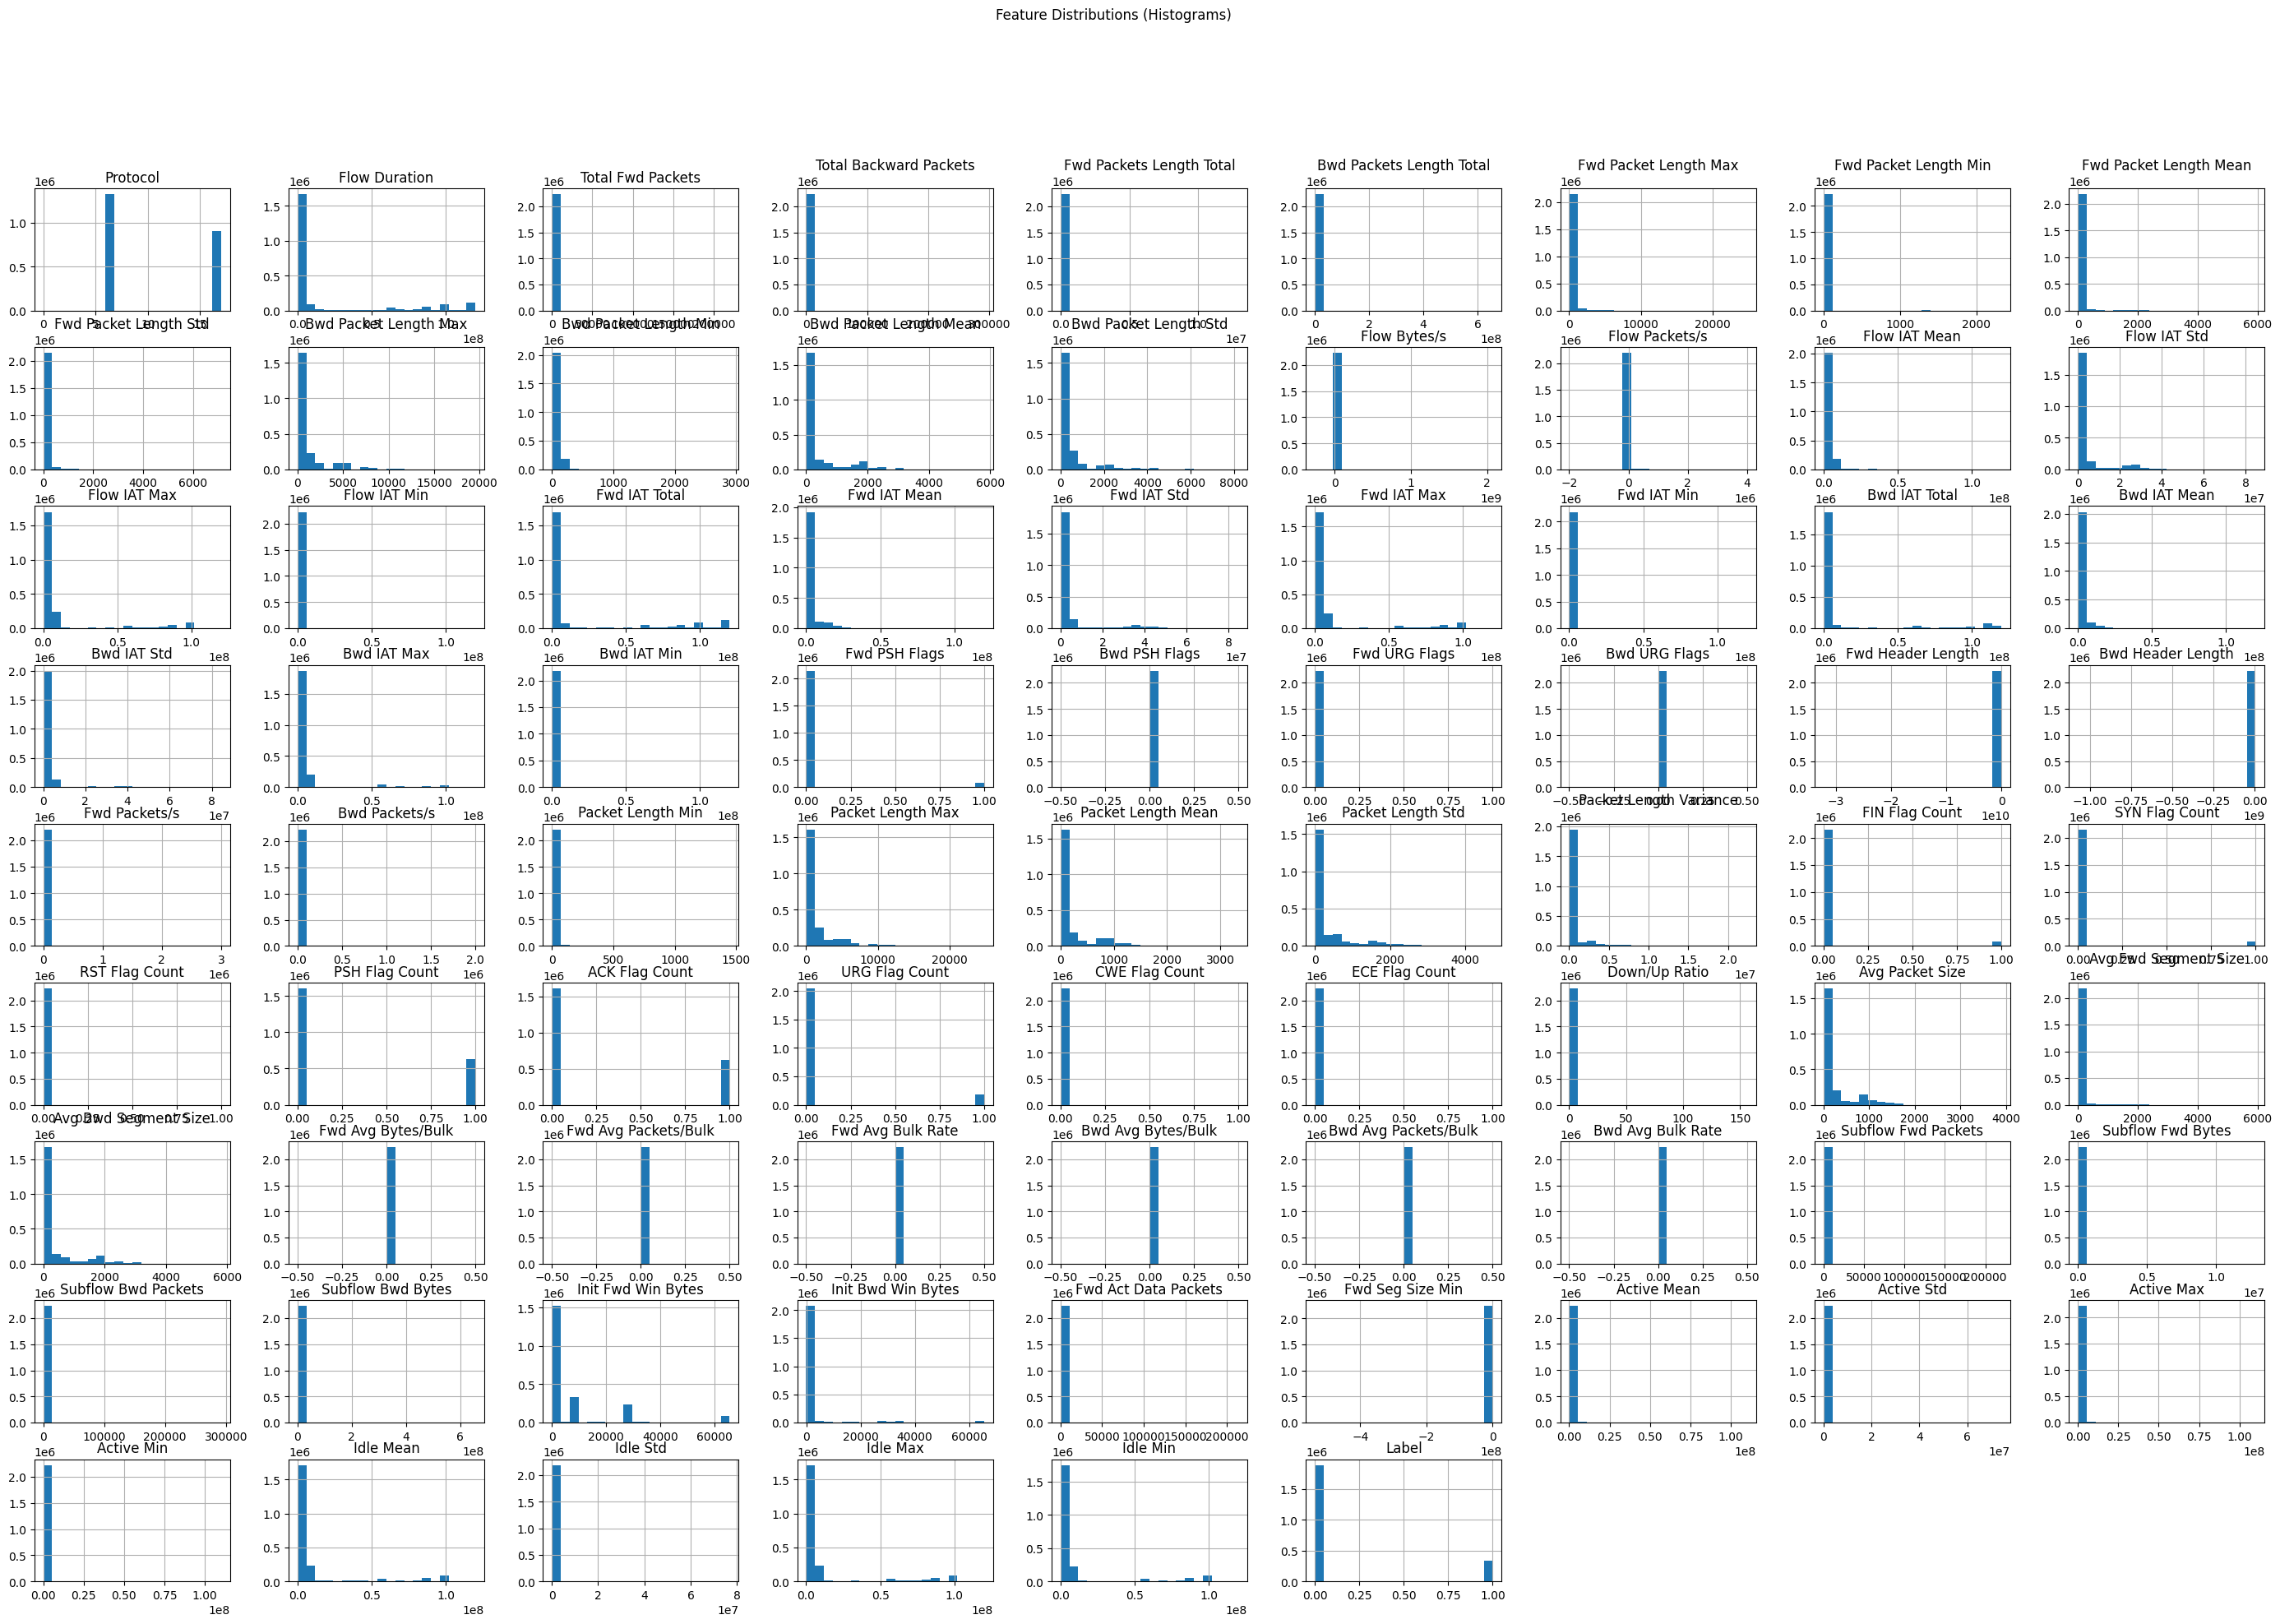

In [ ]:
df.hist(figsize=(35, 22), bins=20)
plt.suptitle('Feature Distributions (Histograms)')
plt.show()

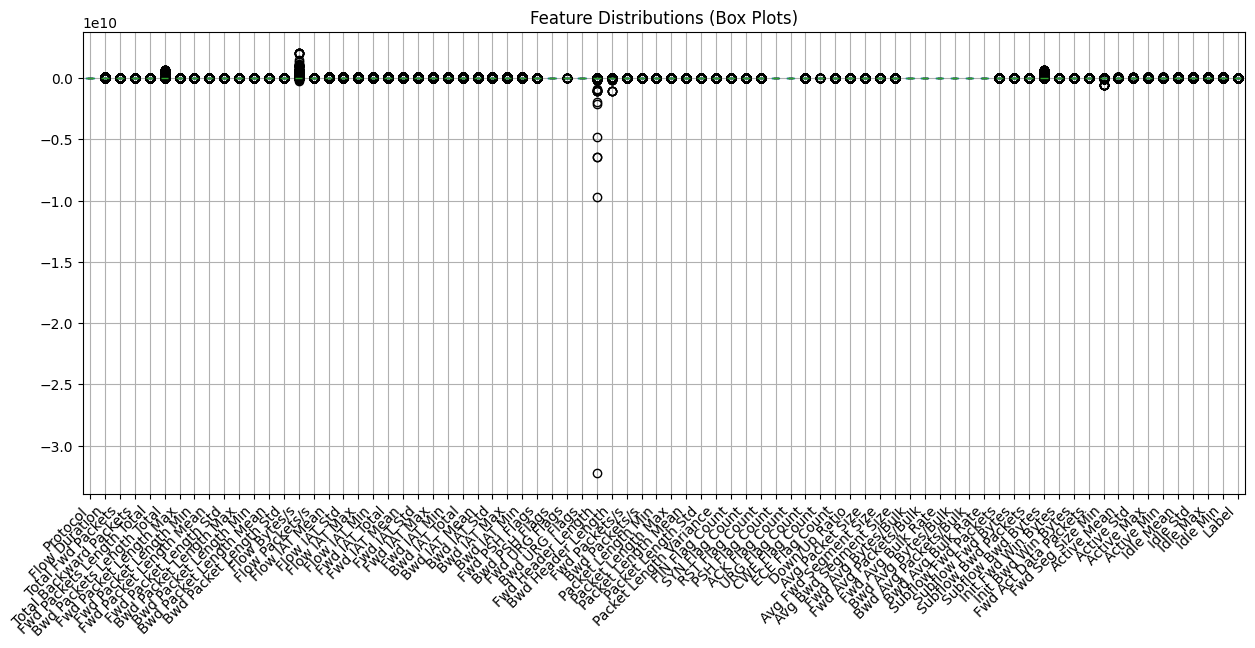

In [ ]:
df.boxplot(figsize=(15, 6))
plt.title('Feature Distributions (Box Plots)')
plt.xticks(rotation=45, ha='right')
plt.show()